In [1]:
import numpy as np
import pandas as pd
import glob

In [2]:
da = pd.DataFrame()
for f in glob.glob("*.xlsx"):
    df = pd.read_excel(f)
    df["Source"] = f.split('.')[0]
    da = da.append(df,ignore_index=True)

In [3]:
# cleanup input (remove empty columns)
da = da.loc[:,:'Source']

# remove aggregate rows
da = da.drop(da[da.Player.isin(['Total','Opponents',''])].index)

# Capitalise name
da['Source'] = da['Source'].str.title()

# rename selected columns
da.rename(columns={'AVG.1': 'PPG', 'AVG': 'MPG', 'TOT':'MIN', 'TOT.1':'REB', 'AVG.2':'RPG'}, inplace=True)

# Only one player is a fifth year, so treat as a senior
da['Class'] = da['Class'].replace(['Fifth'],'Senior')

In [4]:

# new features
da['PPM'] = da['PPG'] / da['MPG']
da['EFF'] = da['PTS'] + da['REB'] + da['AST'] + da['STL'] + da['BLK'] - (da['FGA'] - da['FGM']) - (da['3PTA'] - da['3PT'])  - (da['FTA'] - da['FTM']) - da['TO']
da['EPG'] = da['EFF'] / da['GP']
da['EPM'] = da['EFF'] / da['MIN']
da['EPGM'] = da['EPG'] / da['MIN']

""" players <- players %>%
  mutate(PPM = PPG/MPG,
         EFF = (PPG + RPG + APG + SPG + BPG - (FGA-FGM) - (THREEPA - THREEPM) - (FTM-FTA) - TOPG),
         POS = 0.96 * (FGA + THREEPA + TOPG + (0.44 * FTA)),
         TWOPP = if_else(TWOPA==0,0,TWOPM/TWOPA)) """

' players <- players %>%\n  mutate(PPM = PPG/MPG,\n         EFF = (PPG + RPG + APG + SPG + BPG - (FGA-FGM) - (THREEPA - THREEPM) - (FTM-FTA) - TOPG),\n         POS = 0.96 * (FGA + THREEPA + TOPG + (0.44 * FTA)),\n         TWOPP = if_else(TWOPA==0,0,TWOPM/TWOPA)) '

In [5]:
# League and Team ranking by efficiency
da['L.Rank.EPG'] = da['EPG'].rank(method='average',numeric_only=True,ascending=False)
da['T.Rank.EPG'] = da.groupby('Source')['EPG'].rank(method='average',ascending=False)



In [6]:
def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot(rot=rot, return_type="axes", vert=False)
     


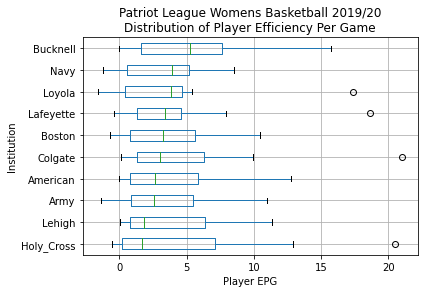

In [7]:
tmp = da[['Source','EPG']]

ax = boxplot_sorted(tmp, by=['Source'], column="EPG")
ax.set(xlabel='Player EPG',ylabel='Institution',title='Patriot League Womens Basketball 2019/20\nDistribution of Player Efficiency Per Game')

ax.figure.savefig('patriot_epg_boxplot.png')


In [8]:
da[['Player','Source','Class','EPG','L.Rank.EPG','T.Rank.EPG']].sort_values('L.Rank.EPG',ascending=True).head(10)

,Player,Source,Class,EPG,L.Rank.EPG,T.Rank.EPG
61,"Thompson, Rachel",Colgate,Senior,21.033333,1.0,1.0
78,"Manis, Lauren",Holy_Cross,Senior,20.466667,2.0,1.0
92,"Kucowski, Natalie",Lafeyette,Junior,18.655172,3.0,1.0
124,"Karcz, Stephanie",Loyola,Senior,17.379310,4.0,1.0
47,"Mack, Ellie",Bucknell,Senior,15.700000,5.0,1.0
80,"Swords, Megan",Holy_Cross,Senior,12.900000,6.0,2.0
0,"Edwards, Jade",American,Sophomore,12.724138,7.0,1.0
49,"Brugler, Tessa",Bucknell,Junior,12.071429,8.0,2.0
121,"Benz, Cameryn",Lehigh,Senior,11.379310,9.0,1.0
120,"Buhr, Camryn",Lehigh,Senior,11.344828,10.0,2.0


In [9]:
# temprorarily add a total column for sorting institutions
tmp = da.groupby(['Source','Class'])['EPG'].median().unstack(1)
tmp['Total'] = tmp.sum(axis=1)
tmp.sort_values('Total',ascending=True,inplace=True)
tmp.drop(columns=['Total'],inplace=True)

tmp



Class,Freshman,Junior,Senior,Sophomore
Source,,,,
Lehigh,0.864583,1.966667,4.996296,1.727586
Boston,4.269231,1.719828,3.935737,1.545455
Army,3.571429,1.800000,0.921429,5.451613
Navy,-0.181818,4.200000,5.185065,3.888889
Holy_Cross,0.042857,1.194444,5.900000,6.037037
Loyola,2.433036,2.553571,3.774074,4.642857
Lafeyette,1.333333,5.964286,4.357143,3.406534
Colgate,2.217391,2.340000,8.966667,2.883333
American,1.000000,9.466667,4.800000,3.777778


In [ ]:
# convert class (year) to a category so that x labels are ordered
# from pandas.api.types import CategoricalDtype
# class_labels = ['Freshman','Sophomore','Junior','Senior']
# class_type = CategoricalDtype(categories = class_labels, ordered = True)
# tmp['Class'] = tmp['Class'].astype(class_type)

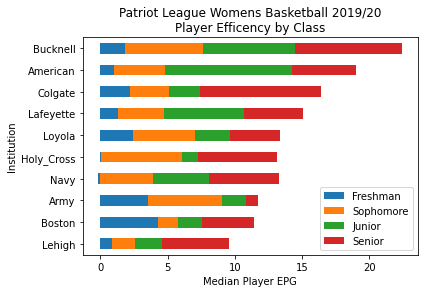

In [10]:
# sort stacked bars by class
class_labels = ['Freshman','Sophomore','Junior','Senior']
tmp.columns = pd.CategoricalIndex(tmp.columns.values, 
                                 ordered=True, 
                                 categories=class_labels)

# Sort the columns (axis=1) by the new categorical ordering
tmp = tmp.sort_index(axis=1)

ax = tmp.plot(kind='barh',ylim=(0,0.1),legend=True,stacked=True)
ax.set(xlabel="Median Player EPG", ylabel="Institution",title="Patriot League Womens Basketball 2019/20\nPlayer Efficency by Class")

ax.figure.savefig('patriot_epg_class.png')


In [11]:
# Team stats
# ?? recompute percentages

def get_team_stats(da):
    dt = da.groupby('Source').sum()

    dt = dt.drop(['Number','L.Rank.EPG','T.Rank.EPG'],axis=1)

    dt['FG%'] = dt['FGM'] / dt['FGA']
    dt['3PT%'] = dt['3PT'] / dt['3PTA']
    dt['FT%'] = dt['FTM'] / dt['FTA']

    mean_cols = ['PPM','EFF','EPG','EPM']
    dt[mean_cols] = da.groupby('Source')[mean_cols].median()

    dt['Rank.EPG'] = dt['EPG'].rank(ascending=False)

    dt = dt.sort_values('Rank.EPG',ascending=True)

    return(dt)



In [ ]:
get_team_stats(da)


In [12]:
# filter out seniors from players
# recompute team EPGiciency ranking

dn = da.drop(da[da.Class.isin(['Senior','Fifth'])].index)

dn['L.Rank.EPG'] = dn['EPG'].rank(method='average',numeric_only=True,ascending=False)
dn['T.Rank.EPG'] = dn.groupby('Source')['EPG'].rank(method='average',ascending=False)

team = get_team_stats(dn)

team['Delta'] = team['EPG'] - team['EPG'].shift(1)

team

,GP,GS,MIN,MPG,FGM,FGA,FG%,3PT,3PTA,3PT%,...,TO,STL,BLK,PPM,EFF,EPG,EPM,EPGM,Rank.EPG,Delta
Source,,,,,,,,,,,,,,,,,,,,,
Bucknell,232.0,118.0,4972,191.3,531,1260,0.421429,167,436,0.383028,...,282,166,74,0.249431,113.0,5.258102,0.235234,0.103062,1.0,NaN
Loyola,169.0,63.0,3379,151.7,355,974,0.364476,101,338,0.298817,...,240,94,34,0.304348,71.0,4.107143,0.156250,0.074303,2.0,-1.150959
Army,266.0,141.0,5568,235.7,638,1597,0.399499,205,601,0.341098,...,508,155,58,0.320000,88.0,3.571429,0.164884,0.143116,3.0,-0.535714
Boston,222.0,131.0,5289,201.2,526,1317,0.399393,177,509,0.347741,...,381,151,68,0.258640,68.5,3.211494,0.193789,1.045221,4.0,-0.359934
Lafeyette,193.0,89.0,4008,190.9,406,1061,0.382658,119,383,0.310705,...,298,123,107,0.231513,30.0,2.578947,0.154896,0.115754,5.0,-0.632547
Colgate,210.0,79.0,3040,127.3,276,751,0.367510,81,252,0.321429,...,174,111,33,0.241935,42.0,2.217391,0.240000,0.190702,6.0,-0.361556
Lehigh,228.0,56.0,3181,110.6,384,1003,0.382851,114,370,0.308108,...,202,99,42,0.280303,48.0,1.666667,0.133787,0.066773,7.0,-0.550725
American,224.0,90.0,4300,153.5,420,1086,0.386740,105,372,0.282258,...,338,163,75,0.215686,37.0,1.541667,0.202186,0.303655,8.0,-0.125000
Navy,179.0,62.0,3333,177.8,323,911,0.354555,94,336,0.279762,...,259,149,35,0.169154,13.0,0.862069,0.076923,0.068716,9.0,-0.679598


In [ ]:
# filter by freshmen
# relative contribution to teams

d0 = da.drop(da[da.Class!='Freshman'].index)

d0.groupby('Source').sum()